In [1]:
import transportation_tutorials as tt

# Accessing OpenStreetMap Data

There are a variety of publicly available geographic data sources which can
be tapped to support various transportation service analysis.

One popular resource is [OpenStreetMap](https://www.openstreetmap.org), which is a public, 
community supported geographic data service, which provides
data on transportation infrastructure and a variety of other geographic data.  Much of
this data can be accessed easily from Python using the open source OSMnx package, which
loads data into GeoPandas and/or NetworkX formats.

In [2]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
import numpy as np

## Municipal Boundaries

Let's get and display the boundary for Jupiter, Florida.  First we'll use the OSMnx package to pull this 
directly from the Open Street Map service, as a geopandas [GeoDataFrame](http://geopandas.org/reference.html#geodataframe).
This type of data access is available as a one-line command.

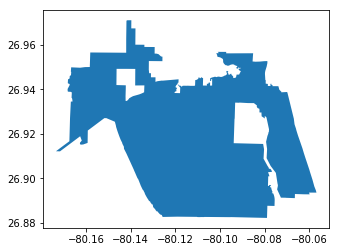

In [3]:
city = ox.gdf_from_place('Jupiter, Florida, USA')
ax = city.plot()

That's roughly the shape of the town.  We can compare against the town's own boundary file, which
they conveniently publish online as well as a zipped shapefile.

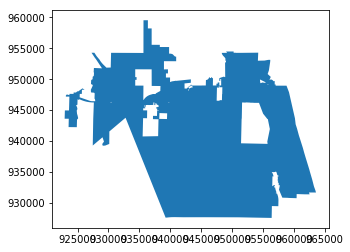

In [4]:
official_shp = tt.download_zipfile("http://www.jupiter.fl.us/DocumentCenter/View/10297")
city_official = gpd.read_file(official_shp)
ax = city_official.plot()

Well that's pretty close, although they are a bit different.
The data on open street map is commmunity maintained and the 
quality of the data is... uneven.  But it's free and portable,
so may be useful for certain contexts.

One important thing to notice is the axis labels-- the town's
official boundary file uses a different coordinate system.  Whenever
we want to use multiple geographic files together, they need
to be using the same coordinate systems, otherwise the data will 
not align properly.  In the example below, the two plots of the 
town are in opposite corners of the map (and the red one in the
lower left corner is too small to see at all).

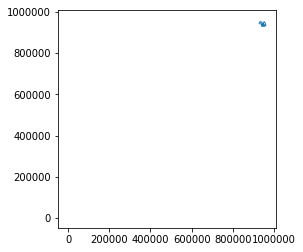

In [5]:
ax = city_official.plot()
ax = city.plot(ax=ax, edgecolor='red')

Fortunately, it's easy to
check which coordinate reference system (*crs*) is used for each GeoDataFrame,
by accessing the [crs](http://geopandas.org/projections.html#coordinate-reference-systems) attribute.

In [6]:
city.crs, city_official.crs

({'init': 'epsg:4326'}, {'init': 'epsg:2881'})

Changing the crs for a GeoDataFrame is simple as well.

In [7]:
city.to_crs(epsg=2881, inplace=True)

Now both files use the same coordinate system.

In [8]:
city.crs, city_official.crs

({'init': 'epsg:2881', 'no_defs': True}, {'init': 'epsg:2881'})

And we can plot these together on the same map, to see the differences more clearly.

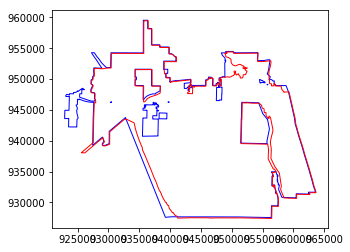

In [9]:
transparent = (0,0,0,0)
ax = city_official.plot(edgecolor='blue', facecolor=transparent)
ax = city.plot(ax=ax, edgecolor='red', facecolor=transparent)

Adding a basemap using the tool provided with the tutorials package can
help give some context to the differences.

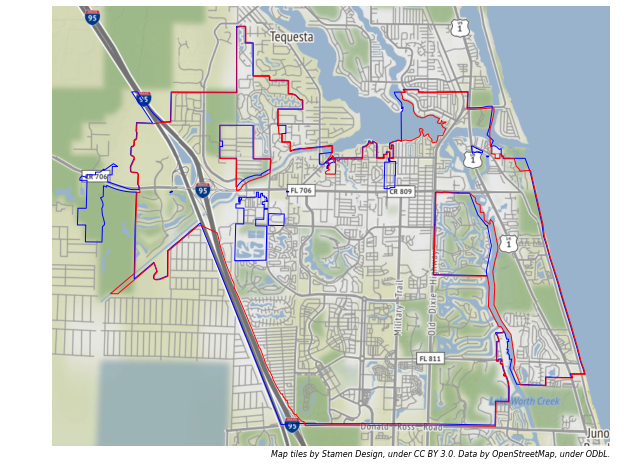

In [10]:
ax = city_official.plot(edgecolor='blue', facecolor=transparent)
ax = city.plot(ax=ax, edgecolor='red', facecolor=transparent)
ax = tt.mapping.add_basemap(ax=ax, zoom=13, epsg=2881, axis='off', figsize=(10,10))

## Street Networks

The OSMnx package can also download a street network.  We can do so again with
a one line command, to get all the streets in Jupiter.

In [12]:
jupiter_streets = ox.graph_from_place('Jupiter, Florida, USA')

Using the [plot_graph](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.plot.plot_graph) 
function from the OSMnx package, we can easily
visualize the network we have downloaded.

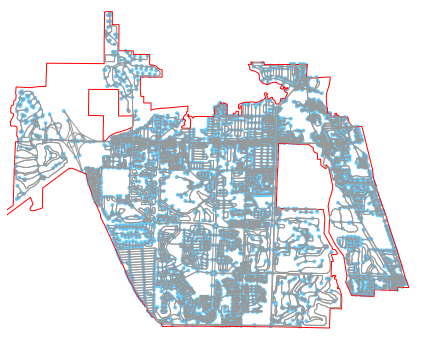

In [13]:
fig, ax = ox.plot_graph(jupiter_streets, show=False, close=False)
ax = city.to_crs(epsg=4326).plot(ax=ax, edgecolor='red', facecolor=transparent)

You may notice that we have only received street segments fully contained with
the reported municipal boundaries of the town.  Some important connectivity
is lost, for example in the eastern section of town, which appears here as
a peninsula, but in reality is not; Donald Ross Road, which marks the southern
edge of town, actually continues east all the way to intersect with Ocean Drive.
To capture this connectivity, we can instead define a study area that 
extends beyond the actual town boundaries.  Here, we'll add a buffer around
the town of a few miles, to get a more complete street network.

In [14]:
study_area = city.buffer(20000).envelope.to_crs(epsg=4326)

The size of the buffer is defined in units based on the coordinate
system of the GeoDataFrame being buffered.  Since the city object
has previously been set to use [EPSG:2881](https://epsg.io/2881),
the units of the buffer are in feet.

Given a defined study area, we can use a different OSMnx function
to access the street network.  Using [graph_from_bbox](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.graph_from_bbox) 
allows us to download a rectangular area defined by latitude
and longitude.

In [15]:
west, south, east, north = study_area.total_bounds
streets = ox.graph_from_bbox(north, south, east, west, simplify=False)

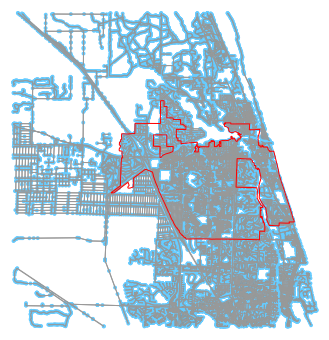

In [16]:
fig, ax = ox.plot_graph(streets, show=False, close=False)
ax = city.to_crs(epsg=4326).plot(ax=ax, edgecolor='red', facecolor=transparent, zorder=2)

The resulting object we receive from either function is a 
[networkx.MultiDiGraph](https://networkx.github.io/documentation/networkx-1.10/reference/classes.multidigraph.html),
which represents a directed graph with loops and parallel edges.  
(Here, a "graph" is interpreted as in "graph theory", not as in 
a picture, although obviously we can create visualizations from
the graph.)

In [17]:
type(streets)

networkx.classes.multidigraph.MultiDiGraph

We can inspect the nodes and edges of the graph seperately to get
an understanding of how much street network we actually received.

In [18]:
len(streets.nodes), len(streets.edges)

(79541, 161919)

### Highway Types

There is actually quite a bit of meta-data attached to the network as well.
We can inspect data on any particular edge if we know the start and end
nodes.

In [19]:
streets.edges[5379723376, 5379723385, 0]

{'osmid': 202361740,
 'oneway': True,
 'lanes': '3',
 'ref': 'FL 706',
 'name': 'West Indiantown Road',
 'highway': 'primary',
 'maxspeed': '45 mph',
 'length': 77.802}

More commonly, we'll want to analyze the network in a more aggregate fashion.
As an example, we'll run tought all the links and tally up the total number of
links with each of the unique 'highway' labels in the network.

In [20]:
highway_types = []
for i in streets.edges.values():
    highway_types.append(str(i['highway']))
unique_highway_types, count_highway_types = np.unique(highway_types, return_counts=True)
link_type_counts = {}
for u, c in zip(unique_highway_types, count_highway_types):
    link_type_counts[u] = c
link_type_counts

{'cycleway': 454,
 'footway': 8780,
 'motorway': 511,
 'motorway_link': 681,
 'path': 23524,
 'primary': 1871,
 'primary_link': 239,
 'residential': 67821,
 'secondary': 179,
 'service': 43658,
 'steps': 30,
 'tertiary': 6758,
 'tertiary_link': 123,
 'track': 5882,
 'unclassified': 1408}

It's also possible to condense all that stuff into one line of python code:

In [21]:
dict(zip(*np.unique([str(i['highway']) for i in streets.edges.values()], return_counts=True)))

{'cycleway': 454,
 'footway': 8780,
 'motorway': 511,
 'motorway_link': 681,
 'path': 23524,
 'primary': 1871,
 'primary_link': 239,
 'residential': 67821,
 'secondary': 179,
 'service': 43658,
 'steps': 30,
 'tertiary': 6758,
 'tertiary_link': 123,
 'track': 5882,
 'unclassified': 1408}

#### Remove Minor Link Types

As you can observe above, the OpenStreetMap network includes a whole lot of content, including 
(at least in Jupiter) a lot of pedestrian and minor links.  Let's abandon all these low level links.

In [22]:
major_types = {
    'motorway', 'motorway_link', 
    'primary', 'primary_link',
    'secondary', 'secondary_link', 
    'tertiary', 'tertiary_link',
}
streets.remove_edges_from( [ 
    k for (k,v) in streets.edges.items() 
    if v.get('highway') not in major_types
] )

In [23]:
len(streets.nodes), len(streets.edges)

(79541, 10362)

We've removed a large number of links, although so far all the nodes remain.

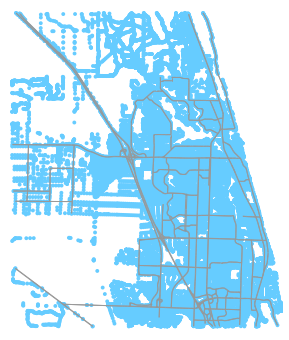

In [24]:
fig, ax = ox.plot_graph(streets)

There are a lot of leftover unconnected nodes -- when we dropped 
the footpaths and minor streets, we didn't drop footpath nodes.  Let's do that now.

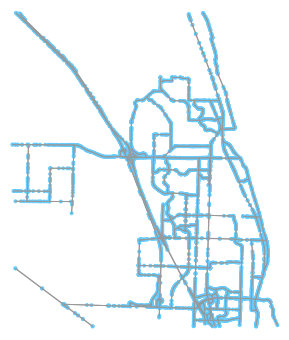

In [25]:
streets.remove_nodes_from(
    list(nx.isolates(streets)) # list-ify to gather nodes first then remove them
)
fig, ax = ox.plot_graph(streets)

Better!  How much network now?

In [26]:
len(streets.nodes), len(streets.edges)

(7484, 10362)

#### Check for Unconnected Network Parts

To check for network connectivity, we'll find shortest paths from one central node to all other nodes.

In [27]:
jupiter_center = 382641489 # Node at Northbound Old Dixie at Westbound Indiantown

# Nodes that can be reached from jupiter_center
connected_nodes_out = set(nx.shortest_path(streets, source=jupiter_center, weight='length').keys())

# Nodes that can reach jupiter_center
connected_nodes_in = set(nx.shortest_path(streets, target=jupiter_center, weight='length').keys())

# Nodes that are full connected 
connected_nodes = connected_nodes_out & connected_nodes_in

# The rest
unconnected_nodes = [node for node in streets.nodes() if node not in connected_nodes]

Let's view a map of the unconnected nodes.

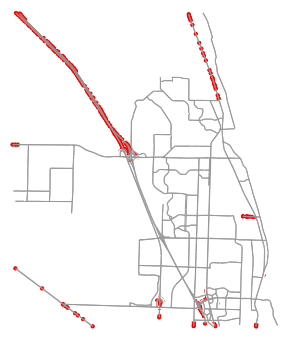

In [28]:
nc = ['w' if node in connected_nodes else 'r' for node in streets.nodes()]
fig, ax = ox.plot_graph(streets, node_color=nc)

Looks like the unconnected nodes are mostly divided highways that enter or leave the study area.
This makes sense, and in a complete demand model these would get external stations
at the ends.  But let's just drop them for this example.

In [29]:
streets.remove_nodes_from(unconnected_nodes)

In [30]:
len(connected_nodes), len(streets)

(6695, 6695)

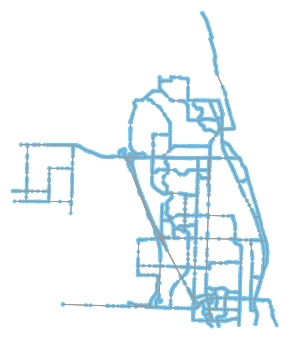

In [31]:
fig, ax = ox.plot_graph(streets)